# Project: Capstone Project - Inferential Statistics

At this point, you have obtained the data set for your Capstone project, cleaned and wrangled it into a form that's ready for analysis. It's now time to apply the inferential statistics techniques you have learned to explore the data. For example, are there variables that are particularly significant in terms of explaining the answer to your project question? Are there strong correlations between pairs of independent variables, or between an independent and a dependent variable? Submission: Write a short report (1-2 pages) on the inferential statistics steps you performed and your findings. Check this report into your github and submit a link to it. Eventually, this report can be incorporated into your Milestone report.

**This report is intended to present some inferential statistical analysis associated with the project.  The main goal of the Capstone project is to assess skill in predicting snowfall events based on meteorological conditions, looking at relationships between meteorological variables and snowfall totals and events will be beneficial.  Three main tests were addressed in this particular report:  
I.) What is confidence there is normality in the data?  
II.) Is there is linear relationship between meteorological variables and snowfall?  
III.) Are frequency distributions of meteorological variables during snowfall events the same as the frequency distributions associated with non-snowfall events? **


## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [2]:
data = [pd.read_csv('asos_snotel_inter_clean_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_df= pd.concat(data)

asos_snotel_df.rename(columns={'CloudCover':'CloudCover_oktas'}, inplace=True)

asos_snotel_df = asos_snotel_df.interpolate(limit=3)
#asos_snotel_df['Julian_Day'] = asos_snotel_df.index.to_julian_date()

print(asos_snotel_df.head())


                     TOBS.I-1 (degC)   SNWD.I-1 (in)   Temperature_degC  \
Date_Time                                                                 
2006-01-01 01:00:00              -2.8            43.0              -1.0   
2006-01-01 02:00:00              -2.9            43.0              -3.0   
2006-01-01 03:00:00              -3.3            43.0              -4.0   
2006-01-01 04:00:00              -3.2            43.0              -4.0   
2006-01-01 05:00:00              -3.2            43.0              -5.0   

                     Dewpoint_degC  Pressure_hp  WindDirection_deg  \
Date_Time                                                            
2006-01-01 01:00:00           -7.0          NaN              220.0   
2006-01-01 02:00:00           -8.0          NaN              230.0   
2006-01-01 03:00:00           -8.0          NaN              230.0   
2006-01-01 04:00:00           -9.0          NaN              240.0   
2006-01-01 05:00:00           -8.0          NaN       

**Create a dataset which calculates the delta 12-hour snowdepth and 12-hour snowfall columns.  The delta 12-hour snowdepth contains the raw differences between snowdepth observations every 12 hours.  The 12-hour snowfall column will only include observations greater then or equal to 3 inches due to spurious nature of the snow depth measurements.  This will be useful for as snowfall is an important dependent variable **

In [3]:
fig = plt.figure(figsize=(10,5))

#Calculate 12-snowfall column by finding difference between 12-hr snow depth observations 
asos_snotel_df['12hr_SNWD_in'] = asos_snotel_df['SNWD.I-1 (in) '].resample('12H').last()
asos_snotel_df['12hr-dSNWD_in'] = asos_snotel_df['12hr_SNWD_in']-asos_snotel_df['12hr_SNWD_in'].shift(+12)
asos_snotel_df['12hr-SNOWFALL_in'] = asos_snotel_df['12hr-dSNWD_in'][asos_snotel_df['12hr-dSNWD_in']>=3]

#print(asos_snotel_df['12hr-dSNWD_in'].describe())
print(asos_snotel_df['12hr-SNOWFALL_in'].describe())


count    343.000000
mean       4.376024
std        2.096673
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       18.000000
Name: 12hr-SNOWFALL_in, dtype: float64


<Figure size 720x360 with 0 Axes>

**Do some quick timeseries plots to visually see the data:**

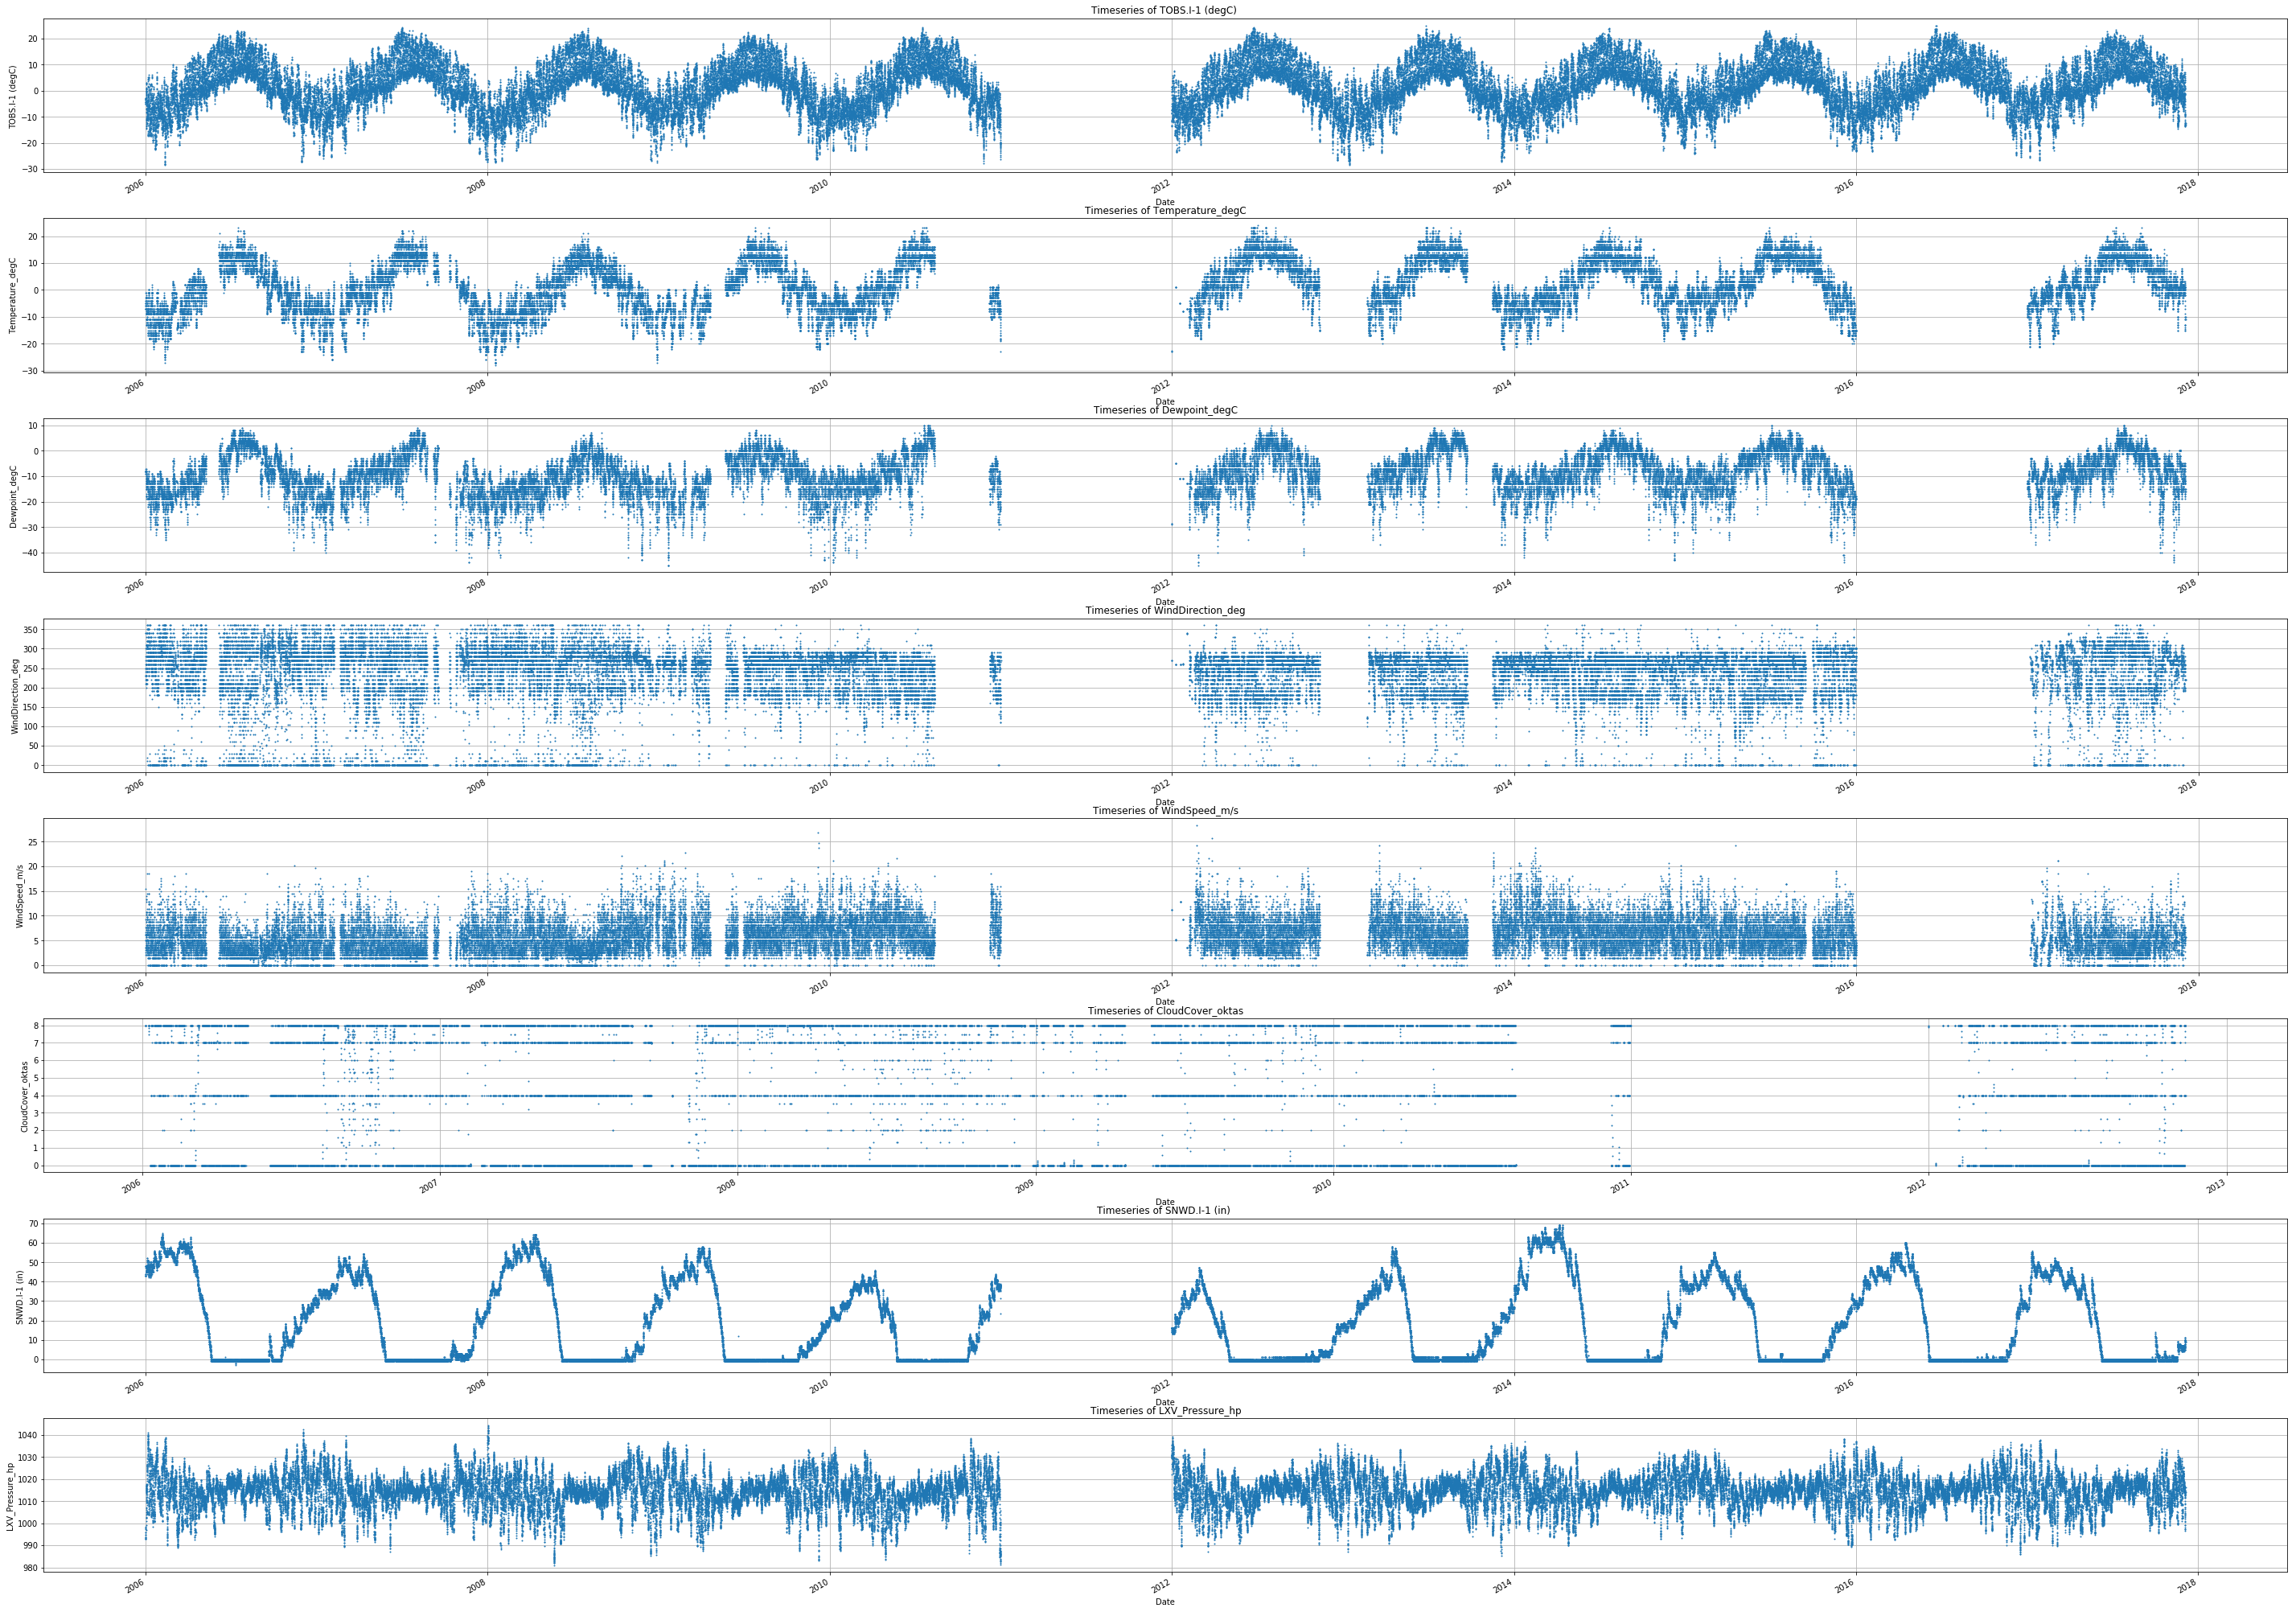

In [4]:
ax = None
%matplotlib inline
#%matplotlib notebook
keys = ['TOBS.I-1 (degC) ','Temperature_degC', 'Dewpoint_degC', 'WindDirection_deg', 'WindSpeed_m/s', 'CloudCover_oktas', 'SNWD.I-1 (in) ', 'LXV_Pressure_hp']
fig = plt.figure(figsize=(50,75))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for k in range(len(keys)):
    ax = plt.subplot(15, 1, k+1)
    asos_snotel_df[keys[k]]['2005':'2017'].plot(linestyle='None', ax = ax, marker = ".", markersize = 2)
    ax.set_xlabel("Date")
    ax.set_ylabel(keys[k])
    
    plt.title("Timeseries of " + keys[k])
 
    plt.grid()
    plt.axis('tight')
  

plt.show()



** &#8657; Some notes:  
There is a a lot of missing data for year 2011 and 2016 - this should be kept in mind as it could skew some our analyeses slightly  **



----

----


## I.) Normality Test
**Normality is an important prequsisite for application of frequentist tests.  Here,  the SciPy's Anderson-Darling test was used to test the null hypothesis that a sample is drawn from a population that follows a particular distribution (in this case, a Normal Distribution).  In addition, p values using the SciPy NormTest function are calculated.  The NormTest function uses the D’Agostino’s K^2 test the same hypotheses at a 5% confidence level. Plots using Seaborns distplot function are also created to help visualize normality potential.**

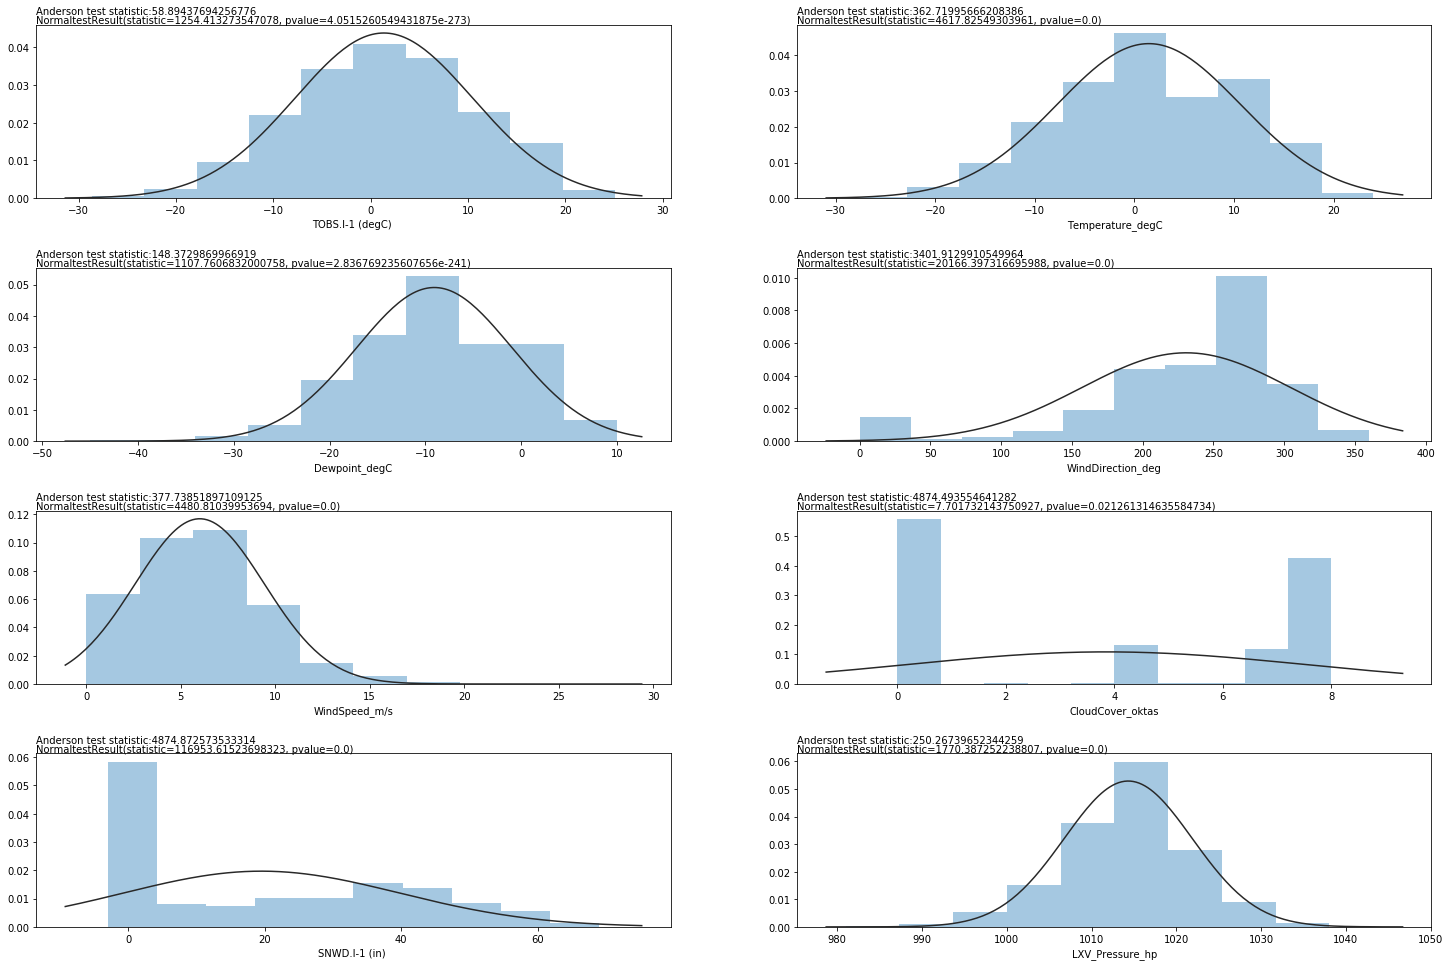

In [5]:
%matplotlib inline
from scipy import stats
from scipy.stats import mode
from scipy.stats import norm

keys = ['TOBS.I-1 (degC) ','Temperature_degC', 'Dewpoint_degC', 'WindDirection_deg', 'WindSpeed_m/s', 'CloudCover_oktas', 'SNWD.I-1 (in) ', 'LXV_Pressure_hp']
years = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']




fig = plt.figure(figsize=(25,30))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
for k in range(len(keys)):
    ax = plt.subplot(7, 2, k+1)
    
    
    normtest = stats.normaltest( asos_snotel_df[keys[k]].dropna())
    andtest = stats.anderson( asos_snotel_df[keys[k]].dropna())
    
    #sl, cv = andtest.significance_level[i], result.critical_values[i]
    x = pd.Series(asos_snotel_df[keys[k]].dropna(), name=keys[k])
    ax = sns.distplot(x, norm_hist = True, fit=norm, kde=False, bins = 10)
    plt.annotate(str(normtest),
                 xy=(0, 1.01), xycoords='axes fraction', fontsize=10)
    plt.annotate("Anderson test statistic:" + str(andtest.statistic), xy=(00, 1.06), xycoords='axes fraction', fontsize=10)
   
    
plt.show()



**For the Anderson tests, the critical test values are as follows:  
15% Confidence Interval: 0.576  
10% Confidence Interval: 0.656  
5% Confidence Interval: 0.787  
2.5% Confidence Interval: 0.918  
1% Confidence Interval: 1.092  **

**The Anderson test statistics returned are much higher then these critical test values for all variables, indicating that the data was not drawn from a normally distributed data at the 99% Confidence level. In addition p values using the NormTest function are extremely low, indicating data is not normally distributed from a significance standpoint at the 5% Confidence Level.  However, it can be seen that some of the data does visually take on normally distributed behavior.. this is especcially true for the Temperature, Dewpoint and Pressure dstributions.  Due to the categorical nature of cloud cover and nonlinear behavior of wind direction, the tests for normality for those datasets are not meaningful. **  


---
---

***


## II.) Check to see if there is linear relationship between meteorological variables and snowfall

**Linear Regression plots were created and regression statistics were calculated using SciPy's linegress function:**

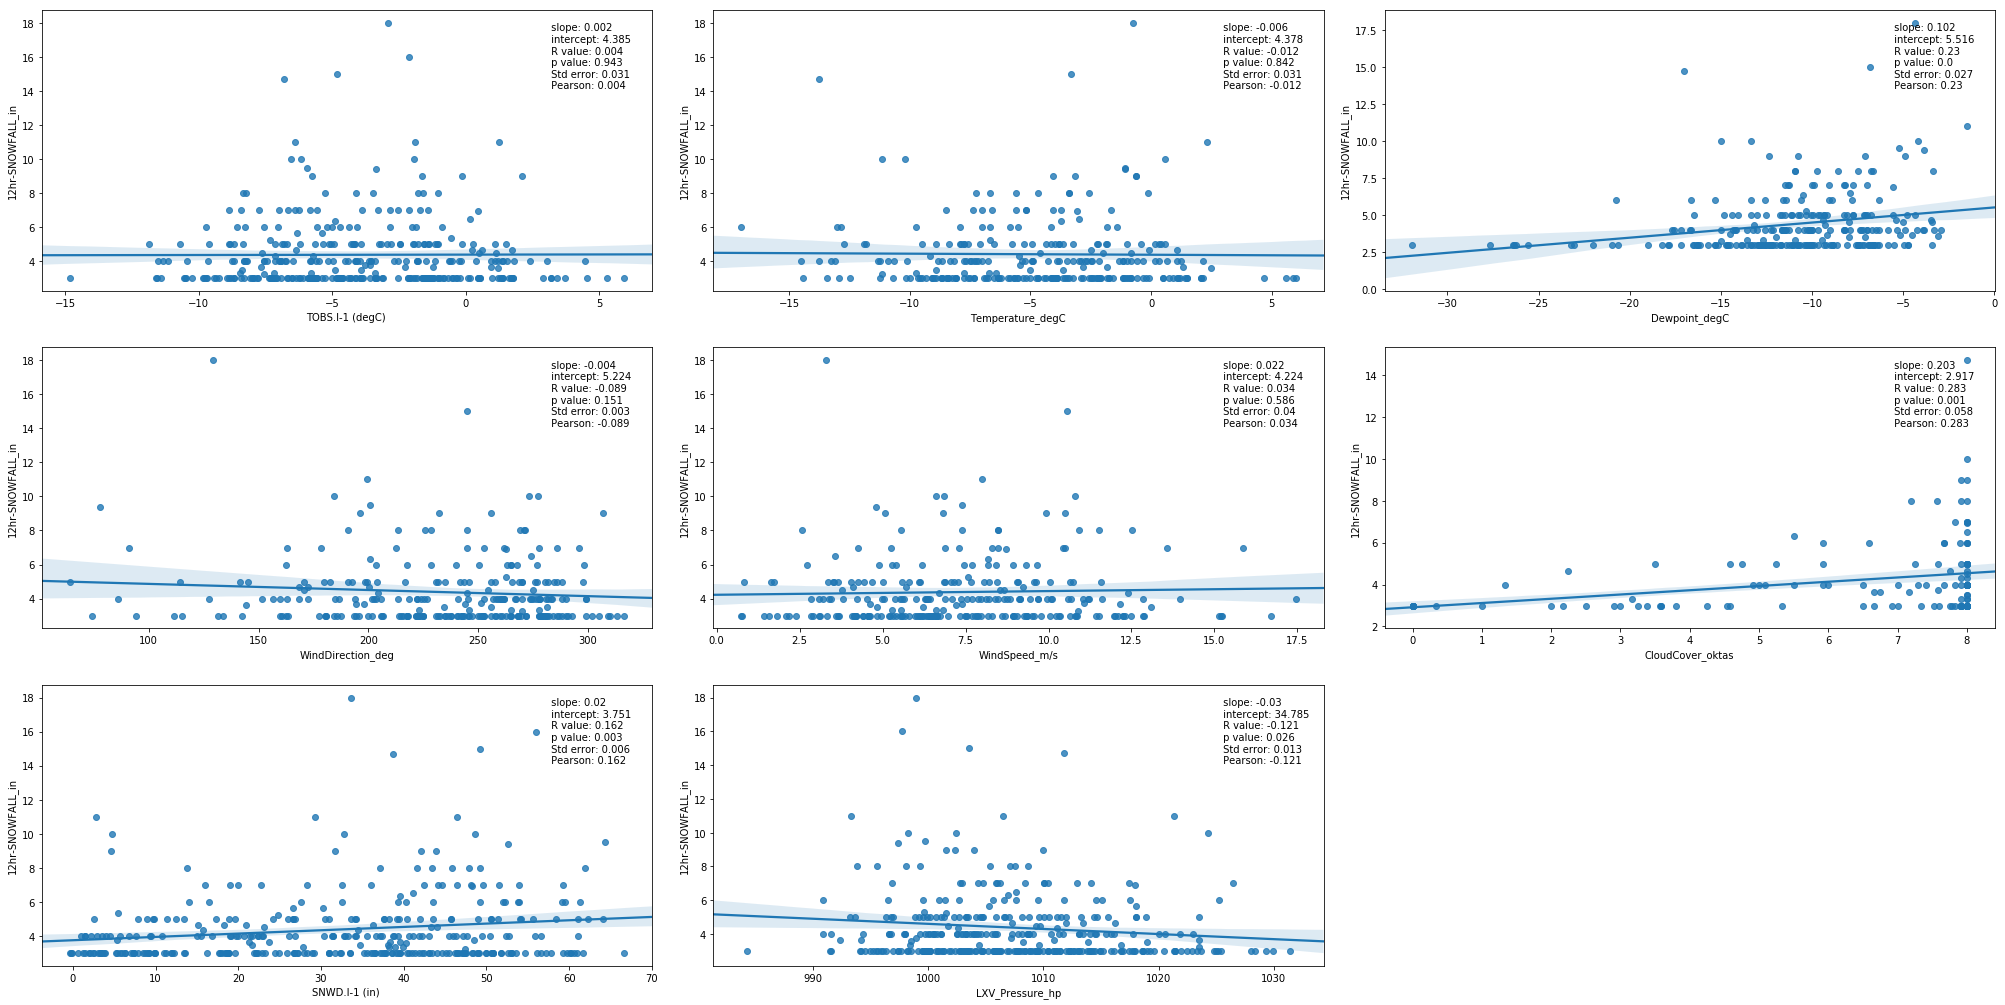

In [6]:
from scipy.stats import pearsonr, linregress
keys = ['TOBS.I-1 (degC) ','Temperature_degC', 'Dewpoint_degC', 'WindDirection_deg', 'WindSpeed_m/s', 'CloudCover_oktas', 'SNWD.I-1 (in) ', 'LXV_Pressure_hp']


fig = plt.figure(figsize=(35,30))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
yy = None

yy = (asos_snotel_df['12hr-SNOWFALL_in']>=3)
snf_df = asos_snotel_df['12hr-SNOWFALL_in'][yy]



for k in range(len(keys)):
    xx_df = None
    plt.subplot(5,3,k+1)

    xx_df = asos_snotel_df[keys[k]].resample('12H').mean()


    idx = np.isfinite(xx_df) & np.isfinite(snf_df)
    sns.regplot(xx_df[idx], snf_df[idx])
    
    pearson, pv = pearsonr(xx_df[idx], snf_df[idx])
    slope, intercept, r_value, p_value, std_err = linregress(xx_df[idx], snf_df[idx])
    

    plt.annotate(' slope: ' + str(round(slope,3)) +
                 '\n intercept: ' + str(round(intercept,3)) + 
                 '\n R value: ' + str(round(r_value,3)) +  
                 '\n p value: ' + str(round(p_value,3)) + 
                 '\n Std error: ' + str(round(std_err,3)) +
                 '\n Pearson: ' + str(round(pearson,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=10)
                                      
#    print()
#    print(str(keys[k]))
#    print('slope: '+ str(slope))
#    print('intercept:')
plt.show()




** **

**From these plots, we can see some small relationship between snowfall amounts for some meteorological variables.  **

**Note that The lineregress function tests the hypothesis that there is no relationship between tested variables (i.e. test whether the slope of the linear regression line is zero).  For Dewpoint and Pressure, we can confidently reject that hypothesis as the returned p values are less then 0.05. The p value returned for Cloud Cover was 0.052, just over 0.05 indicating fairly strong confidence as well.  Here are a few notes on each linear regression relationship for each variable:  **
* **SNOTEL Temperature (TOBS (deg C)): shows very little linear relationship with snowfall.  However, one should note there is a parabolic shape to the datapoints in the SNOTEL Temperature plot.** 
* **ASOS Temperature (Temperture_degC): same as SNOTEL Temerature.** 
* **Dewpoint: Snowfall events tend to occur at higher dewpoints, and none occur when dewpoints are greater then 0 deg C.  Physically, this would be expected as colder air cannot hold too much moisture.**
* **Wind Direction:  While there does appear to be a slight positive correlation, Wind Direction is not physically a linear measurement.  Therefore, this relationship should be applied cautiously.**  
* **Wind Speed:  Here we see a very slight positive relationship between snowfall totals and wind speed.  The Pearson coefficient is quite low here.**  
* **Cloud Cover:  Of all the variables, Cloud Cover shows the strongest relationship of all the variables (highest R value and Pearson coefficient, along with smallest p value).  This would be expected as larger snowstorms would tend to occur during extended cloudy periods.  However, this relationship should be viewed with caution as first, cloud cover is a categorical variable.  Second, cloud cover values were found to be primarily 0, 4, or 8, so there is little resolution to the data.  Also, cloud cover from years 2015-2017 were removed due to anomalous data (see outlier tab) where no the max data reported was only four. By removing these three years, the cloud cover-snowfall relationship did improve substantially.**
* **Snow Depth (SNWD) - Interestingly, there is a relationship here although physically snowdepth cannot be a variable which affects snowfall amounts.  This relationship is likely due to climatology - larger snowfall may tend to occur in March/April timeframe whenever snowpack has developed already.  This relationship could be investigated further.**  
* **Pressure:  This is another variable which appears to have a relationship with snowfall based on its p value.  Physically, one would expect higher snowfall amounts during periods of lower pressure.  This is indeed what we are seeing.  Another thing to check is pressure changes (3-hr, 24-hr, etc) to see if there is any relationship between snowfall amounts and pressure trends.**


***


***  






# III.) Relationship between Snowfall events and Frequencies of occurrence of Meteorological Variables

**To begin, all meteorological variables must be reasonably binned. Bin each variable in a consistent format resampling every 12H**

In [7]:
from scipy.stats import mode
def bin_df_data(df, bin_ranges):  
    binned_df = df.copy()
    binned_df[:] = np.NaN
    
    for t in range(1, len(bin_ranges)):
        binned_df[(df[:] >= bin_ranges[t-1]) & (df[:] < bin_ranges[t])] = (bin_ranges[t]+ bin_ranges[t-1])/2
    
    binned_df.columns = ['bin']
    return binned_df

#keys = ['Temperature_degC', 'Dewpoint_degC', 'TOBS.I-1 (degC) ']
#temp_range = [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10]

#Bin linear variables###############################################################
temp_range = np.arange(-40, 40, 2)
ws_range = np.arange(0,30, 2)
bp_range = np.arange(986,1040, 2)


binned_12H_Temp = bin_df_data(asos_snotel_df['Temperature_degC'].resample('12H').mean(), temp_range)
ASOStemp_bin_counts = binned_12H_Temp.groupby(binned_12H_Temp).size().reset_index(name='Counts')

binned_12H_TOBS = bin_df_data(asos_snotel_df['TOBS.I-1 (degC) '].resample('12H').mean(), temp_range)
SNOTELtemp_bin_counts = binned_12H_TOBS.groupby(binned_12H_TOBS).size().reset_index(name='Counts')

binned_12H_DP = bin_df_data(asos_snotel_df['Dewpoint_degC'].resample('12H').mean(), temp_range)
DP_bin_counts = binned_12H_DP.groupby(binned_12H_DP).size().reset_index(name= 'Counts')

binned_12H_WS = bin_df_data(asos_snotel_df['WindSpeed_m/s'].resample('12H').mean(), ws_range)
WS_bin_counts = binned_12H_WS.groupby(binned_12H_WS).size().reset_index(name='Counts')

binned_12H_P = bin_df_data(asos_snotel_df['LXV_Pressure_hp'].resample('12H').mean(), bp_range)
print(binned_12H_P.describe())
BP_bin_counts = binned_12H_P.groupby(binned_12H_P).size().reset_index(name='Counts')



## Bin Wind Direction - Due to difficulty with averaging wind direction, the mode will be utilized rather then the mean
bin_wd_df = pd.DataFrame()
binned_WD =  asos_snotel_df['WindDirection_deg'].copy()

binned_WD[(binned_WD >= 337.5) | (binned_WD < 22.5)] = 0
binned_WD[(binned_WD >= 22.5) & (binned_WD < 67.5)] = 45
binned_WD[(binned_WD >= 67.5) & (binned_WD < 112.5)] = 90
binned_WD[(binned_WD >= 112.5) & (binned_WD < 157.5)] = 135
binned_WD[(binned_WD >= 157.5) & (binned_WD < 202.5)] = 180
binned_WD[(binned_WD >= 202.5) & (binned_WD < 247.5)] = 225
binned_WD[(binned_WD >= 247.5) & (binned_WD < 292.5)] = 270
binned_WD[(binned_WD >= 292.5) & (binned_WD< 337.5)] = 315

binned_12H_WD = binned_WD.resample('12H').apply(lambda x: mode(x)[0])
binned_12H_WD = pd.to_numeric(binned_12H_WD, errors='coerce')


##Bin CloudCover - due to the relatively few values found in the CC dataset (mainly 0s, 4s, and 8s), bin this into only two categories - one bin being mostly clear and the other being mostly cloudy
binned_CC = asos_snotel_df['CloudCover_oktas'].copy()
binned_12H_CC = binned_CC.resample('12H').mean()
binned_12H_CC = pd.to_numeric(binned_12H_CC, errors='coerce')
binned_CC[(binned_CC >= 0) | (binned_CC < 5)] = 0
binned_CC[(binned_CC >= 5) | (binned_CC < 9)] = 8

##Bin Snowfall########
binned_SNF = asos_snotel_df['12hr-SNOWFALL_in'].copy()
yy = (binned_SNF <3)
binned_SNF[yy] = np.NaN

binned_SNF[(binned_SNF >= 3.0) & (binned_SNF <5.5) ]= 4
binned_SNF[(binned_SNF >= 5.5) & (binned_SNF< 7.5)] = 6
binned_SNF[(binned_SNF >= 7.5) & (binned_SNF < 9.5)] = 8
binned_SNF[(binned_SNF >= 9.5)] = 10

binned_12H_SNF = binned_SNF.resample('12H').last()



##Put all data in individual dataframe
binned_df = None
binned_df = binned_12H_SNF.to_frame().join(binned_12H_Temp.to_frame(), on = 'Date_Time', how= 'outer') \
                                     .join(binned_12H_TOBS.to_frame(), on = 'Date_Time', how= 'outer')  \
                                     .join(binned_12H_DP.to_frame(), on = 'Date_Time', how= 'outer')  \
                                     .join(binned_12H_WS.to_frame(), on = 'Date_Time', how= 'outer')  \
                                     .join(binned_12H_WD.to_frame(), on = 'Date_Time', how= 'outer')  \
                                     .join(binned_12H_P.to_frame(), on = 'Date_Time', how= 'outer')  \
                                     .join(binned_12H_CC.to_frame(), on = 'Date_Time', how= 'outer')  \



print(binned_df.head())




count    7957.000000
mean     1014.328641
std         7.271452
min       987.000000
25%      1011.000000
50%      1015.000000
75%      1019.000000
max      1037.000000
Name: LXV_Pressure_hp, dtype: float64
                     12hr-SNOWFALL_in  Temperature_degC  TOBS.I-1 (degC)   \
Date_Time                                                                   
2006-01-01 00:00:00               NaN              -5.0              -3.0   
2006-01-01 12:00:00               NaN              -9.0              -7.0   
2006-01-02 00:00:00               NaN             -11.0              -9.0   
2006-01-02 12:00:00               NaN              -5.0               1.0   
2006-01-03 00:00:00               NaN              -3.0              -3.0   

                     Dewpoint_degC  WindSpeed_m/s  WindDirection_deg  \
Date_Time                                                              
2006-01-01 00:00:00           -9.0            5.0              225.0   
2006-01-01 12:00:00          -11.0    

## Does the presence of snowfall affect frequency distributions of meteorological variables?  

** To test this, a plot of binned meteorological will be made when no snowfall is occuring, and another set of plots will be made of binned meteorological variables during snowfall events.  It will be interesting to see if there is an alteration in distributions of meteorological variables during snowfall events.  If there is, it could indicate a dependence between specific meteorological variables and snowfall events. **

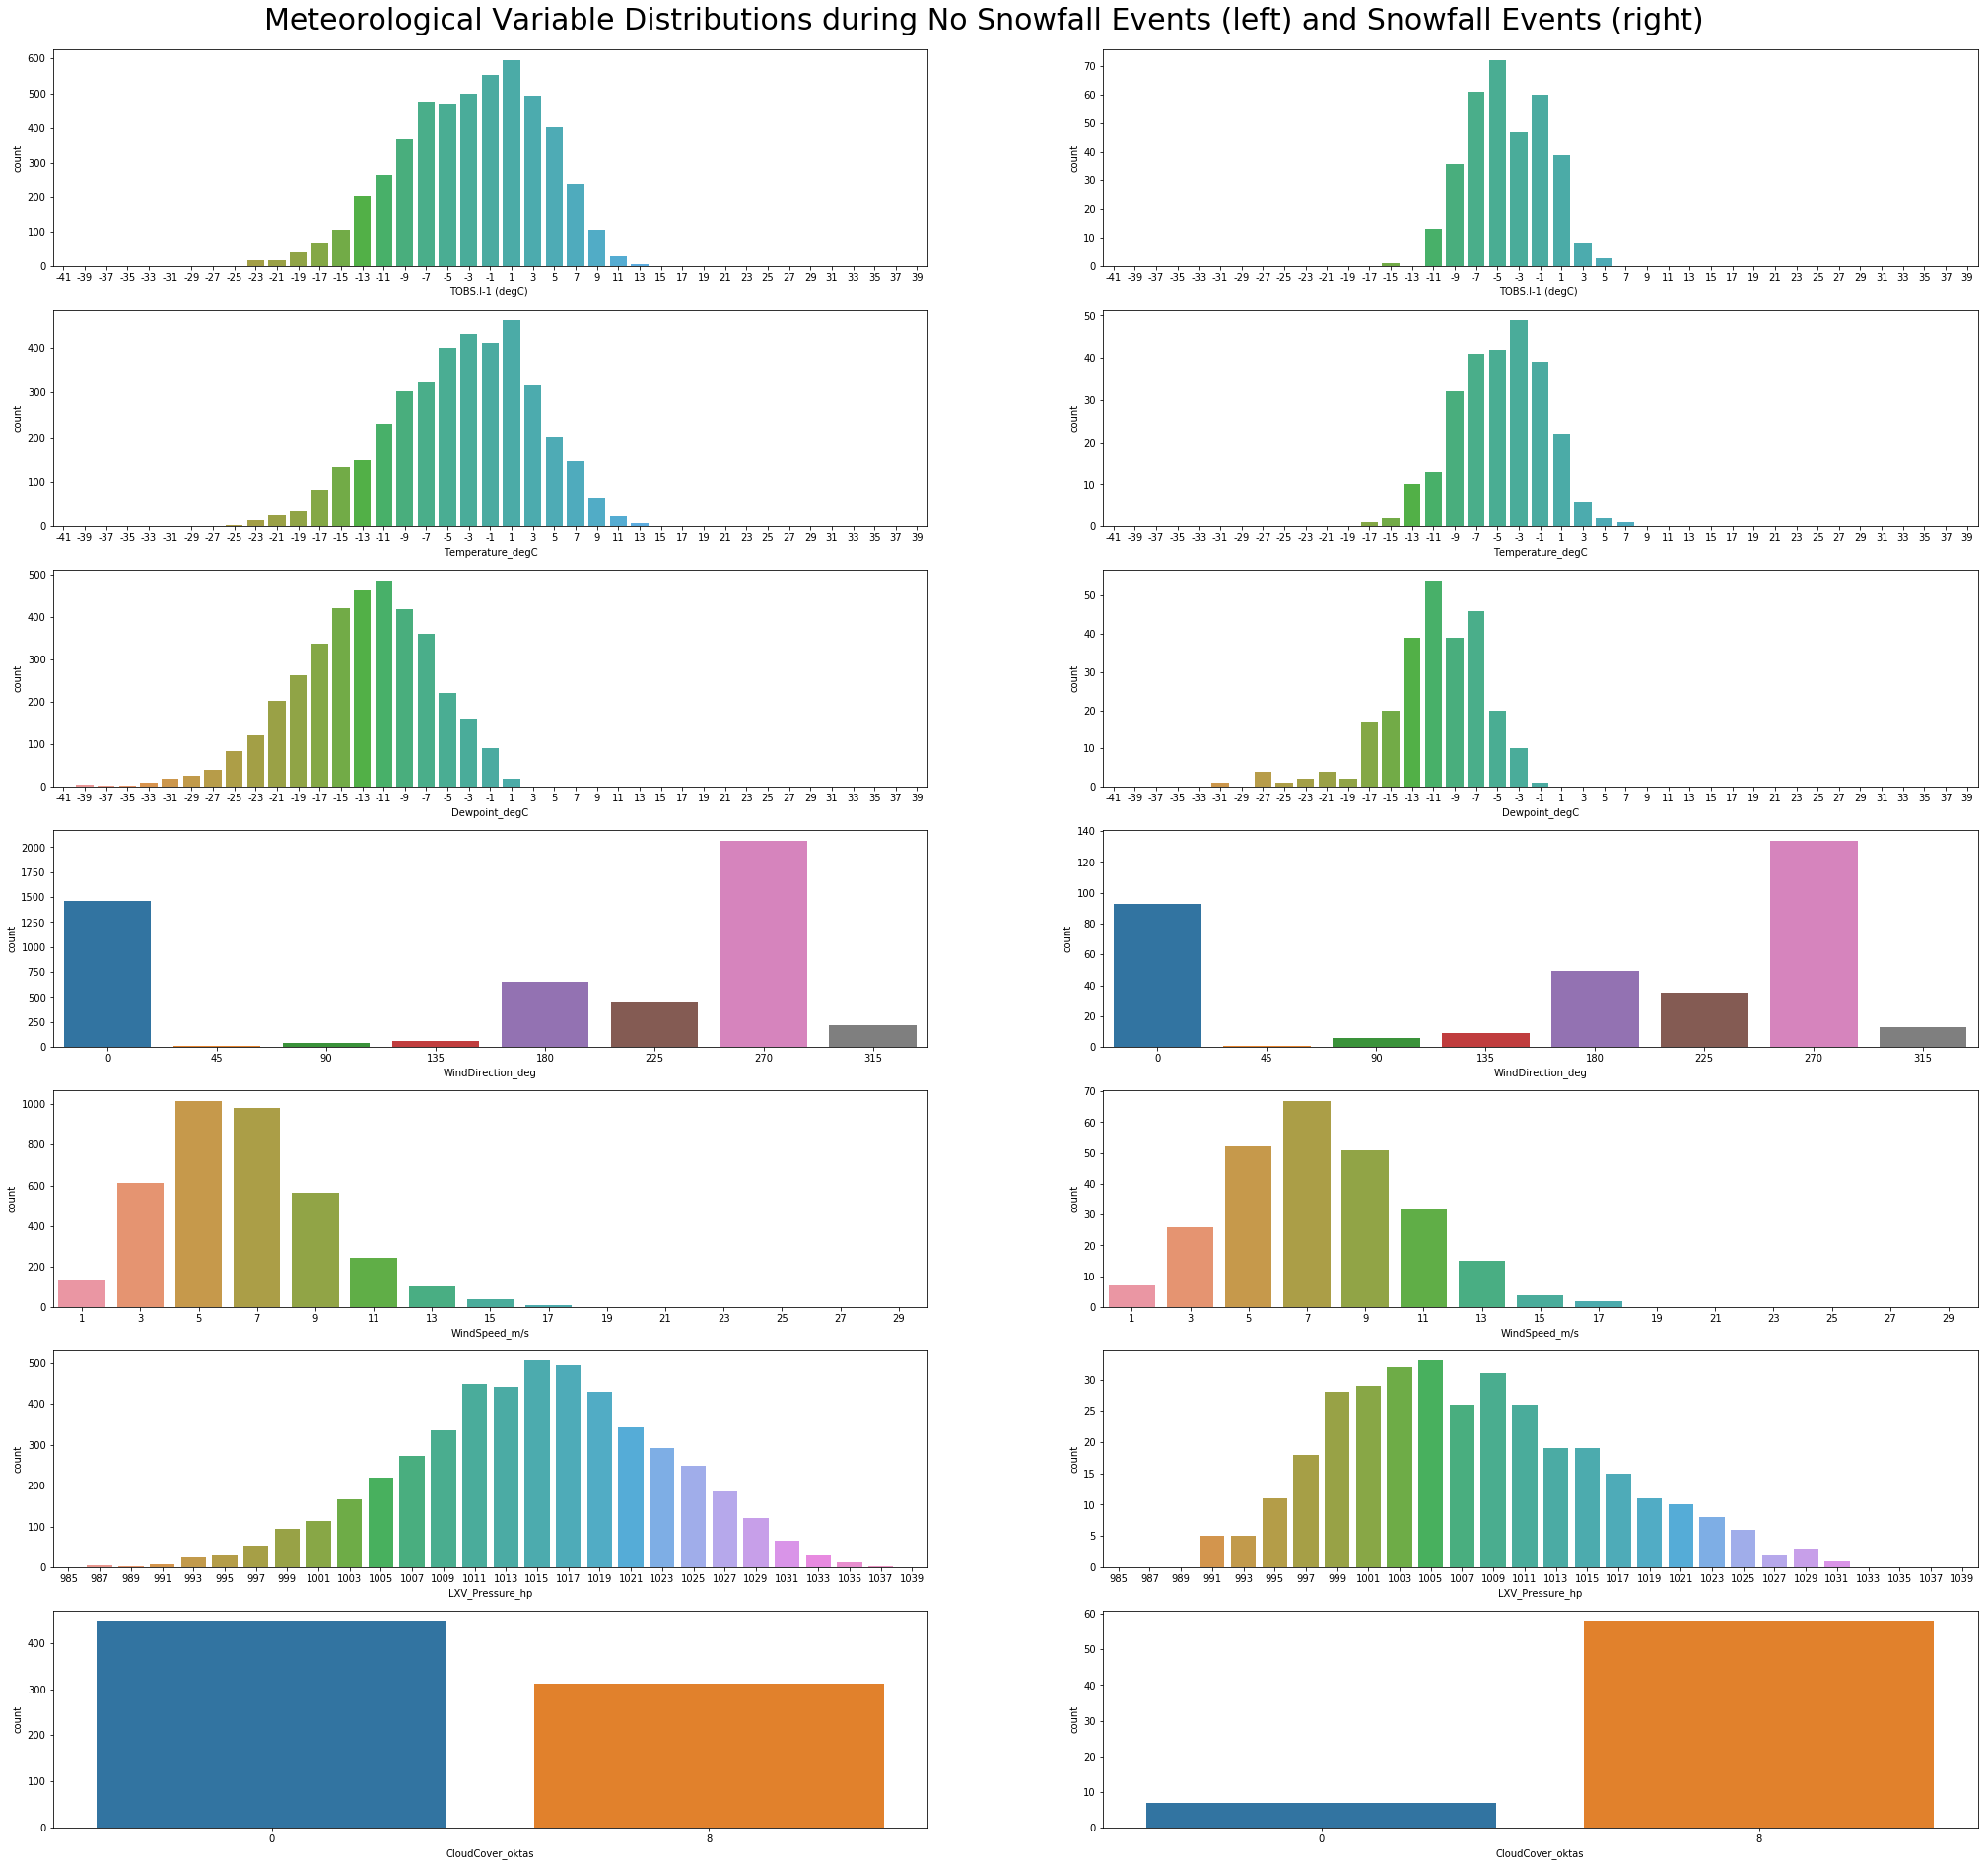

In [8]:


temp_range = np.arange(-41, 41, 2)
ws_range = np.arange(1,31, 2)
bp_range = np.arange(985,1041, 2)
wd_range = np.arange(0,360, 45)
cc_range = [0 ,8]

xx = (binned_df.index.month <=  5) | (binned_df.index.month >=10)
snow = binned_df['12hr-SNOWFALL_in']>=3
nosnow = ~snow
keys = ['TOBS.I-1 (degC) ','Temperature_degC', 'Dewpoint_degC', 'WindDirection_deg', 'WindSpeed_m/s', 'LXV_Pressure_hp', 'CloudCover_oktas']


#print(binned_df['12hr-SNOWFALL_in'])
#for k in range(len(keys)):
##for key in keys:
#    fig = plt.figure( figsize =(30,5)) 
#    fig.add_subplot(121)
#    sns.countplot(binned_df[keys[k]][xx])
#    fig.add_subplot(122)
#    sns.countplot(binned_df[keys[k]][xx][yy])
#fig.add_subplot(422)
#sns.countplot(binned_df['TOBS.I-1 (degC) '][xx][yy])
#fig.add_subplot(423)
#sns.countplot(binned_df['Dewpoint_degC'][xx][yy])
#fig.add_subplot(424)
#sns.countplot(binned_df['WindSpeed_m/s'][xx][yy])
#fig.add_subplot(425)
#sns.countplot(binned_df['WindDirection_deg'][xx][yy])
#fig.add_subplot(426)
#sns.countplot(binned_df['LXV_Pressure_hp'][xx][yy])
#fig.add_subplot(427)
#sns.countplot(binned_df['12hr-SNOWFALL_in'][xx][yy])
#plt.show()

#fig = plt.figure( figsize =(30,5)) 
#fig.suptitle('Counts of Meteorological Variables by Value', fontsize=30)
#fig.add_subplot(131)
#sns.countplot(binned_df['WindDirection_deg'])
#fig.add_subplot(132)
#sns.countplot(binned_df['WindDirection_deg']['2005':'2008'])
#fig.add_subplot(133)
#sns.countplot(binned_df['WindDirection_deg']['2009':'2017'])

fig = plt.figure( figsize =(35,30)) 
fig.suptitle("Meteorological Variable Distributions during No Snowfall Events (left) and Snowfall Events (right)", fontsize = 30)
fig.tight_layout()
fig.subplots_adjust(top=0.96)

fig.add_subplot(721)
sns.countplot(binned_df['TOBS.I-1 (degC) '][xx][nosnow], order=temp_range)

fig.add_subplot(722)
sns.countplot(binned_df['TOBS.I-1 (degC) '][xx][snow], order=temp_range)
#sns.barplot(x = temp_range, y = binned_df['TOBS.I-1 (degC) '][xx][yy])

fig.add_subplot(723)
sns.countplot(binned_df['Temperature_degC'][xx][nosnow], order=temp_range)
fig.add_subplot(724)
sns.countplot(binned_df['Temperature_degC'][xx][snow], order=temp_range)
            
fig.add_subplot(725)
#binned_df['Dewpoint_degC'][xx].value_counts(normalize=True)[temp_range].plot(kind = 'bar')
sns.countplot(binned_df['Dewpoint_degC'][xx][nosnow], order=temp_range)
fig.add_subplot(726)
sns.countplot(binned_df['Dewpoint_degC'][xx][snow], order=temp_range)
                                        

fig.add_subplot(727)
sns.countplot(binned_df['WindDirection_deg'][xx][nosnow], order=wd_range)
fig.add_subplot(7,2,8)
sns.countplot(binned_df['WindDirection_deg'][xx][snow], order=wd_range)

fig.add_subplot(7,2,9)
sns.countplot(binned_df['WindSpeed_m/s'][xx][nosnow], order=ws_range)
fig.add_subplot(7,2,10)
sns.countplot(binned_df['WindSpeed_m/s'][xx][snow], order=ws_range)

fig.add_subplot(7,2,11)
sns.countplot(binned_df['LXV_Pressure_hp'][xx][nosnow], order=bp_range)
fig.add_subplot(7,2,12) 
sns.countplot(binned_df['LXV_Pressure_hp'][xx][snow], order=bp_range)

fig.add_subplot(7,2,13)
sns.countplot(binned_df['CloudCover_oktas'][xx][nosnow], order=cc_range)
fig.add_subplot(7,2,14) 
sns.countplot(binned_df['CloudCover_oktas'][xx][snow], order=cc_range)










**We can see that there is noticable shift in frequency bins for Wind Speed and Pressure. It is apparent that the mean wind speed shifts upward and the mean pressure shifts downward during snowfall events.  Using the chi-square test, we can tests the null hypothesis that the counts of meteorological variables associated with non-snow events data have the same frequencies of occurrence as those associated with snow-events. If snowfall and the meteorological variable are completely independent, one would expect the distributions to be the same.  For the the chi-square test, the no-snow distribution will be considered the expected distribution.  For comparability purposes, the counts in the no-snow frequency bins will be scaled by the ratio of total no-snowfall event counts divided by total snowfall event counts.  **

In [9]:
from scipy.stats import chisquare

##TOBs  ################################################
key = 'TOBS.I-1 (degC) '
x = binned_df[key][xx][nosnow].value_counts(normalize= False)[np.arange(-11,5, 2)].sort_index().tolist()
y = binned_df[key][xx][snow].value_counts(normalize= False)[np.arange(-11,5, 2)].sort_index().tolist()
scaling2 = float(binned_df[key][xx][snow].value_counts().sum())/float(binned_df[key][xx][nosnow].value_counts().sum())
no_snow_bin = [scaling2 * i for i in x]
w_snow_bin = [1 * i for i in y]

cs, pv = chisquare(w_snow_bin, no_snow_bin )

print(key)
print('The chi square test tests the null hypothesis that the counts of meteorological variables associated with non-snow events data has the same frequencies as the counts associated with snow-events')
print("Counts associated with non-snow events (expected frequency): " + str([round(x,1) for x in no_snow_bin]))
print("Counts associated with snow events: " + str([round(x,2) for x in w_snow_bin]))
print(f'Chi-square Statistic : {cs} , p-value: {pv} \n')

##Temperature  ##########################################
key = 'Temperature_degC'
x = binned_df[key][xx][nosnow].value_counts(normalize= False)[np.arange(-13,3, 2)].sort_index().tolist()
y = binned_df[key][xx][snow].value_counts(normalize= False)[np.arange(-13,2, 2)].sort_index().tolist()
scaling2 = float(binned_df[key][xx][snow].value_counts().sum())/float(binned_df[key][xx][nosnow].value_counts().sum())
no_snow_bin = [scaling2 * i for i in x]
w_snow_bin = [1 * i for i in y]
cs, pv = chisquare(w_snow_bin, no_snow_bin )
print(key)
print("Counts associated with non-snow events (expected frequency): " + str([round(x,1) for x in no_snow_bin]))
print("Counts associated with snow events: " + str([round(x,2) for x in w_snow_bin]))
print(f'Chi-square Statistic : {cs} , p-value: {pv} \n')


##Dewpoint  #######################################
key = 'Dewpoint_degC'
x = binned_df[key][xx][nosnow].value_counts(normalize= False)[np.arange(-17,-3, 2)].sort_index().tolist()
y = binned_df[key][xx][snow].value_counts(normalize= False)[np.arange(-17,-3, 2)].sort_index().tolist()
scaling2 = float(binned_df[key][xx][snow].value_counts().sum())/float(binned_df[key][xx][nosnow].value_counts().sum())
no_snow_bin = [scaling2 * i for i in x]
w_snow_bin = [1 * i for i in y]
cs, pv = chisquare(w_snow_bin, no_snow_bin )

print(key)
print("Counts associated with non-snow events (expected frequency): " + str([round(x,1) for x in no_snow_bin]))
print("Counts associated with snow events: " + str([round(x,2) for x in w_snow_bin]))
print(f'Chi-square Statistic : {cs} , p-value: {pv} \n')


##WindSpeed  #######################################
key = 'WindSpeed_m/s'
x = binned_df[key][xx][nosnow].value_counts(normalize= False)[np.arange(1,13, 2)].sort_index().tolist()
y = binned_df[key][xx][snow].value_counts(normalize= False)[np.arange(1,13, 2)].sort_index().tolist()
scaling2 = float(binned_df[key][xx][snow].value_counts().sum())/float(binned_df[key][xx][nosnow].value_counts().sum())
no_snow_bin = [scaling2 * i for i in x]
w_snow_bin = [1 * i for i in y]
cs, pv = chisquare(w_snow_bin, no_snow_bin )

print(key)
print("Counts associated with non-snow events (expected frequency): " + str([round(x,1) for x in no_snow_bin]))
print("Counts associated with snow events: " + str([round(x,2) for x in w_snow_bin]))
print(f'Chi-square Statistic : {cs} , p-value: {pv} \n')



##Wind Direction  ####################################
key ='WindDirection_deg'
x = binned_df[key][xx][nosnow].value_counts(normalize=False)[[0, 90, 135,180, 225, 270, 315]].sort_index().tolist()
y = binned_df[key][xx][snow].value_counts(normalize= False)[[0, 90, 135,180, 225, 270, 315]].sort_index().tolist()
scaling2 = float(binned_df[key][xx][snow].value_counts().sum())/float(binned_df[key][xx][nosnow].value_counts().sum())
no_snow_bin = [scaling2 * i for i in x]
w_snow_bin = [1 * i for i in y]

cs, pv = chisquare(w_snow_bin, no_snow_bin )

print(key)
print("Counts associated with non-snow events (expected frequency): " + str([round(x,1) for x in no_snow_bin]))
print("Counts associated with snow events: " + str([round(x,2) for x in w_snow_bin]))
print(f'Chi-square Statistic : {cs} , p-value: {pv} \n')



##Pressure  ##################################
key = 'LXV_Pressure_hp'
x = binned_df[key][xx][nosnow].value_counts(normalize= False)[np.arange(991,1025, 2)].sort_index().tolist()
y = binned_df[key][xx][snow].value_counts(normalize= False)[np.arange(991,1025, 2)].sort_index().tolist()
scaling2 = float(binned_df[key][xx][snow].value_counts().sum())/float(binned_df[key][xx][nosnow].value_counts().sum())
no_snow_bin = [scaling2 * i for i in x]
w_snow_bin = [1 * i for i in y]

##Cloud Cover  ##################################
key = 'CloudCover_oktas'
x = binned_df[key][xx][nosnow].value_counts(normalize= False)[[0,8]].sort_index().tolist()
y = binned_df[key][xx][snow].value_counts(normalize= False)[[0,8]].sort_index().tolist()
scaling2 = float(binned_df[key][xx][snow].value_counts().sum())/float(binned_df[key][xx][nosnow].value_counts().sum())
no_snow_bin = [scaling2 * i for i in x]
w_snow_bin = [1 * i for i in y]

cs, pv = chisquare(w_snow_bin, no_snow_bin)
print(key)
print("Counts associated with non-snow events (expected frequency): " + str([round(x,1) for x in no_snow_bin]))
print("Counts associated with snow events: " + str([round(x,2) for x in w_snow_bin]))
print(f'Chi-square Statistic : {cs} , p-value: {pv} \n')



TOBS.I-1 (degC) 
The chi square test tests the null hypothesis that the counts of meteorological variables associated with non-snow events data has the same frequencies as the counts associated with snow-events
Counts associated with non-snow events (expected frequency): [18.0, 25.3, 32.7, 32.2, 34.3, 38.0, 40.9, 33.8]
Counts associated with snow events: [13, 36, 61, 72, 47, 60, 39, 8]
Chi-square Statistic : 116.79980230061922 , p-value: 3.551119552711024e-22 

Temperature_degC
Counts associated with non-snow events (expected frequency): [10.2, 15.9, 21.0, 22.3, 27.6, 29.8, 28.4, 32.0]
Counts associated with snow events: [10, 13, 32, 41, 42, 49, 39, 22]
Chi-square Statistic : 48.91347876666259 , p-value: 2.3592533033426307e-08 

Dewpoint_degC
Counts associated with non-snow events (expected frequency): [23.3, 29.2, 32.1, 33.7, 28.9, 24.9, 15.2]
Counts associated with snow events: [17, 20, 39, 54, 39, 46, 20]
Chi-square Statistic : 41.09679048955629 , p-value: 2.7712742417517834e-07 

W

**While this test is not perfect, the p values for all variables with the exception of wind direction, which has a p value >0.05.  This means we can reject the our null hypothesis that the frequency count distributions are the same for all variables except wind direction.  The p value for wind direction is high enough to suggest that we cannot reject the null hypothesis, and there may be no dependency between wind direction and snowfall events.  The other tests indicate that snowfall events possibly have different meteorological variables associated with them. This is good, as The key for future work is to determine what meteorological variables suggest a higher likelihood of snowfall for the model.  This analysis indicates wind speeds are slightly higher during snow events, pressure is typically lower, and the pressure is typically lower. **